In [1]:
import io
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import nltk
import heapq
import numpy as np
import re
import pandas as pd
from nltk.corpus.reader.conll import ConllCorpusReader, LazyConcatenation, LazyMap

In [2]:
# nltk.download('words')
# nltk.download('maxent_ne_chunker')

In [3]:
###Taken from [https://stackoverflow.com/questions/46872083/ne-tags-in-nltk-conllcorpusreader] [14/11/2022]
class betterConllReader(ConllCorpusReader):

    def iob_words(self, fileids=None, tagset=None, column="ne"):
        """
        :return: a list of word/tag/IOB tuples
        :rtype: list(tuple)
        :param fileids: the list of fileids that make up this corpus
        :type fileids: None or str or list
        """
        self._require(self.WORDS, self.POS, self.CHUNK, self.NE)
        def get_iob_words(grid):
            return self._get_iob_words(grid, tagset, column)
        return LazyConcatenation(LazyMap(get_iob_words, self._grids(fileids)))

    def _get_iob_words(self, grid, tagset=None, column="ne"):
        pos_tags = self._get_column(grid, self._colmap['pos'])
        if tagset and tagset != self._tagset:
            pos_tags = [map_tag(self._tagset, tagset, t) for t in pos_tags]
        return list(zip(self._get_column(grid, self._colmap['words']), pos_tags,
                   self._get_column(grid, self._colmap[column])))

###

In [4]:
def read_data(root_filename, datafiles, column_types):
    # data_stream = pyconll.load_from_file(filename)
    # data = parse(data_stream)

    data = betterConllReader(root_filename, datafiles, columntypes=column_types)
    return data


def extract_annotations(inputfile, annotationcolumn, delimiter='\t'):
    '''
    This function extracts annotations represented in the conll format from a file
    
    :param inputfile: the path to the conll file
    :param annotationcolumn: the name of the column in which the target annotation is provided
    :param delimiter: optional parameter to overwrite the default delimiter (tab)
    :type inputfile: string
    :type annotationcolumn: string
    :type delimiter: string
    :returns: the annotations as a list
    '''
    #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
    conll_input = pd.read_csv(inputfile, sep=delimiter, error_bad_lines=False)
    annotations = conll_input[annotationcolumn].tolist()
    return annotations


def get_class_labels_distribution(data):
    labels_counter = defaultdict(int)

    for iob_word in data.iob_words(): 
        labels_counter[iob_word[-1]] += 1

#     del labels_counter["O"]
    return labels_counter

def get_top_k_items_from_dict(dict_, k):
    top_k_counter = defaultdict(str)

    for category_, inside_counter in dict_.items():
        k_keys_sorted = heapq.nlargest(k, inside_counter.items(), key=lambda x: x[1])
        top_k_counter[category_] = k_keys_sorted
    
    return top_k_counter

def get_top_k_words_per_category(data, k=5, category=None):
    words_counter = defaultdict(dict)
    
    for iob_word in data.iob_words():
        word = iob_word[0].lower()
        ne = iob_word[-1]
        if word not in words_counter[ne]:
            words_counter[iob_word[-1]].update({word: 1})
        else:
            words_counter[iob_word[-1]][word] += 1
            
    return get_top_k_items_from_dict(words_counter, k)            
    

def get_top_k_pos_per_category(data):
    pos_counter = defaultdict(dict)
    for iob_word in data.iob_words():
        pos_tag, ne = iob_word[1], iob_word[2]

        if bool(re.search("[a-zA-Z]+", pos_tag)):    
            if pos_tag not in pos_counter[ne]:
                pos_counter[ne].update({pos_tag: 1})
            else:
                pos_counter[ne][pos_tag] += 1
                
    return get_top_k_items_from_dict(pos_counter, k=5)

def plot_top_k_words(top_k_words):
    labels = list(top_k_words.keys())

    width = 0.35

    top_words = []
    top_words_count = []

    for label in labels:
        word, word_count = top_k_words[label][0]
        top_words.append(word)
        top_words_count.append(word_count)

    bar1 = plt.bar(labels, top_words_count)

    for i, rect in enumerate(bar1):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, top_words[i], ha='center', va='bottom')
        
def plot_pos_disribution(top_k_pos_tag):
    class_labels = list(top_k_pos_tag.keys())
    
    fig, ax = plt.subplots(4,2, figsize=(10, 10))
    fig.tight_layout(pad=2.0)
    
    counter = 0
    for i in range(4):
        for j in range(2):
            class_label = class_labels[counter]
            x_labels, y_counts = [], []
            for x_label, y_count in top_k_pos_tag[class_label]:
                x_labels.append(x_label)
                y_counts.append(y_count)
                
            total_count = sum(y_counts)
            y_counts_perc = [round(100.0*count/total_count, 2) for count in y_counts]
            
            ax[i][j].pie(y_counts_perc, startangle=90)
            ax[i][j].title.set_text("POS distribution for {}".format(class_label))
            ax[i][j].axis('equal')
            
            
            ax[i][j].legend(loc='upper left', 
                       labels=['%s, %1.2f%%' % (l, s) for l, s in zip(x_labels, y_counts_perc)], 
                       prop={'size': 11}, 
                       bbox_to_anchor=(0.0, 1)
#                        bbox_transform=fig.transFigure
                      )
            counter += 1
    
#     width = 0.35
#     fig, ax = plt.subplots(4,2, figsize=(10, 10))
#     fig.tight_layout(pad=2.0)

#     counter = 0
#     for i in range(4):
#         for j in range(2):
#             class_label = class_labels[counter]
#             x_labels, y_counts = [], []
#             for x_label, y_count in top_k_pos_tag[class_label]:
#                 x_labels.append(x_label)
#                 y_counts.append(y_count)

#             ax[i][j].bar(x_labels, y_counts)
#             ax[i][j].title.set_text("POS distribution for {}".format(class_label))
#             counter += 1
#     plt.show()
    
def get_capital_words_count(data):
    ortho_counter = defaultdict(int)
    for sent in data.iob_sents():
        for iob_word in sent[1:]:
            if bool(re.search("^[A-Z]", iob_word[0])):
                ortho_counter[iob_word[-1]] += 1
                
    return ortho_counter

def explore(root_filename, datafiles, column_types, plot=False):
    train_data = read_data(root_filename, [datafiles[0]], column_types)
    dev_data = read_data(root_filename, [datafiles[1]], column_types)
    
    exploration_results = dict()
    
    fig, ax = plt.subplots(2,2, figsize=(13, 10))
    fig.tight_layout(pad=4.0)
    
    ## 1. Class label distribution
    train_labels_counter = get_class_labels_distribution(train_data)
    exploration_results["entity count distribution train"] = train_labels_counter
    if plot:
        ax[0][0].bar(list(train_labels_counter.keys()), list(train_labels_counter.values()))
        ax[0][0].title.set_text("Class label distribution for training data")
    
    dev_labels_counter = get_class_labels_distribution(dev_data)
    exploration_results["entity count distribution dev"] = dev_labels_counter
    if plot:
        ax[0][1].bar(list(dev_labels_counter.keys()), list(dev_labels_counter.values()))
        ax[0][1].title.set_text("Class label distribution for dev data")
    
    ## 2. Top word and its count per class
    train_top_k_words = get_top_k_words_per_category(train_data, k=3)
    train_top_k_words
    top_words_dict = dict()
    top_words_count_dict = dict()

    for key, value in train_top_k_words.items():
        top_words_dict[key] = value[0][0]
        top_words_count_dict[key] = value[0][1]

    exploration_results["most occurring word train"] = top_words_dict
    exploration_results["most occurring word count train"] = top_words_count_dict
#     if plot:
#         plot_top_k_words(train_top_k_words)
#         plt.title("Top word per category for training data")
        
    dev_top_k_words = get_top_k_words_per_category(dev_data, k=3)
    top_words_dict = dict()
    top_words_count_dict = dict()

    for key, value in dev_top_k_words.items():
        top_words_dict[key] = value[0][0]
        top_words_count_dict[key] = value[0][1]

    exploration_results["most occurring word dev"] = top_words_dict
    exploration_results["most occurring word count dev"] = top_words_count_dict

#     if plot:
#         plot_top_k_words(dev_top_k_words, ax[1][1])
#         plt.title("Top word per category for dev data")
        
    ## 3. POS tags distribution for each class
    train_top_k_pos_tag = get_top_k_pos_per_category(train_data)
    del train_top_k_pos_tag['O']

    if plot:
        plot_pos_disribution(train_top_k_pos_tag)
        
    dev_top_k_pos_tag = get_top_k_pos_per_category(dev_data)
    del dev_top_k_pos_tag['O']
    
    if plot:
        plot_pos_disribution(dev_top_k_pos_tag)
        
    ## 4. Orthographich features exploration
    train_ortho_counter = get_capital_words_count(train_data)
    exploration_results["capital words train"] = train_ortho_counter
        
    if plot:
        ax[1][0].bar(train_ortho_counter.keys(), train_ortho_counter.values())
        ax[1][0].title.set_text("Distribution of words having first letter as \n Captial for different classes(train)")

    dev_ortho_counter = get_capital_words_count(dev_data)
    exploration_results["capital words dev"] = dev_ortho_counter
        
    if plot:
        ax[1][1].bar(dev_ortho_counter.keys(), dev_ortho_counter.values())
        ax[1][1].title.set_text("Distribution of words having first letter as \n Captial for different classes(dev)")
        
    if plot:
        plt.show()
        
    exploration_df = pd.DataFrame.from_dict(exploration_results)
    exploration_df.to_csv("./data_exploration_results.csv")

In [5]:
root_filename = "../../data/"
datafiles = ["conll2003.train.conll", "conll2003.dev.conll"]
column_types = ["words", "pos", "chunk", "ne"]

In [6]:
train_data = read_data(root_filename, [datafiles[0]], column_types)
dev_data = read_data(root_filename, [datafiles[1]], column_types)

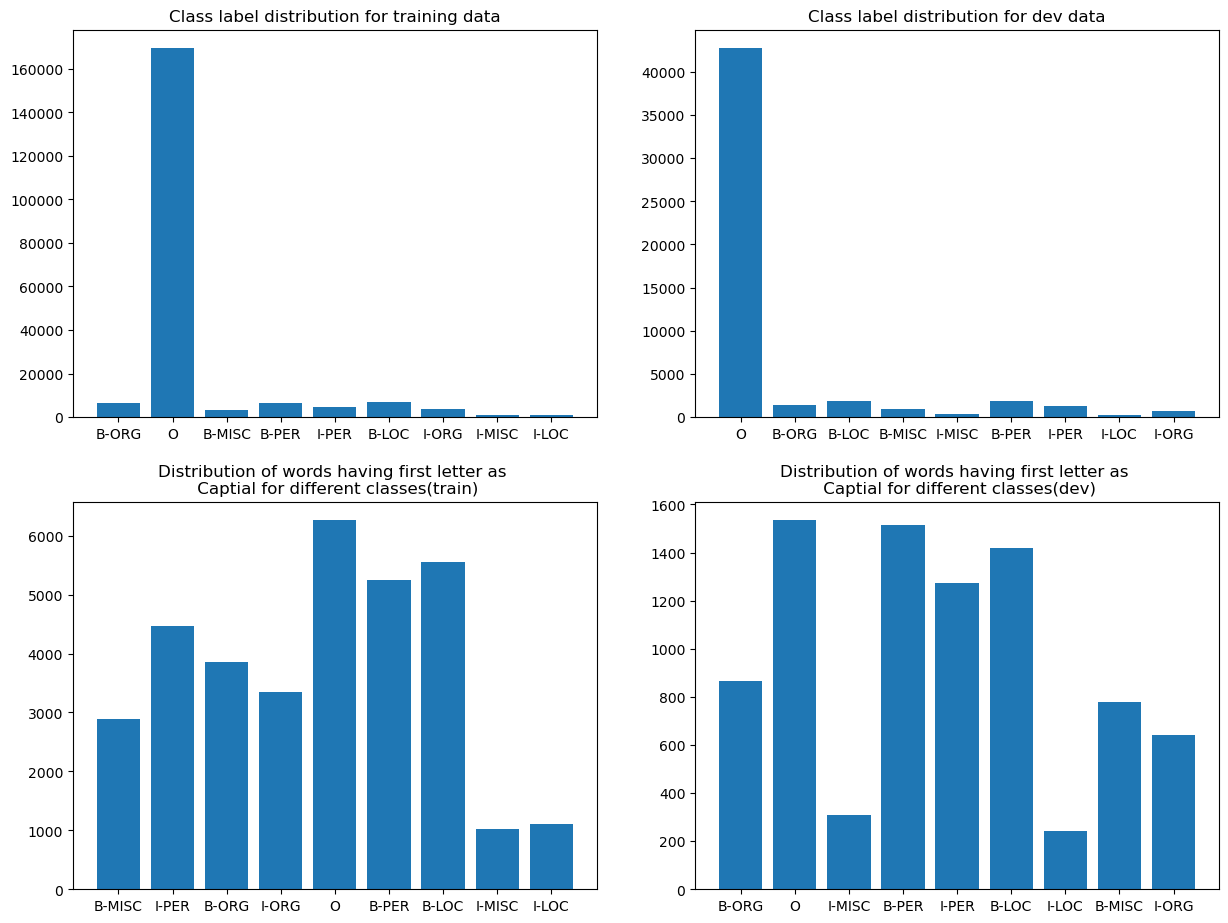

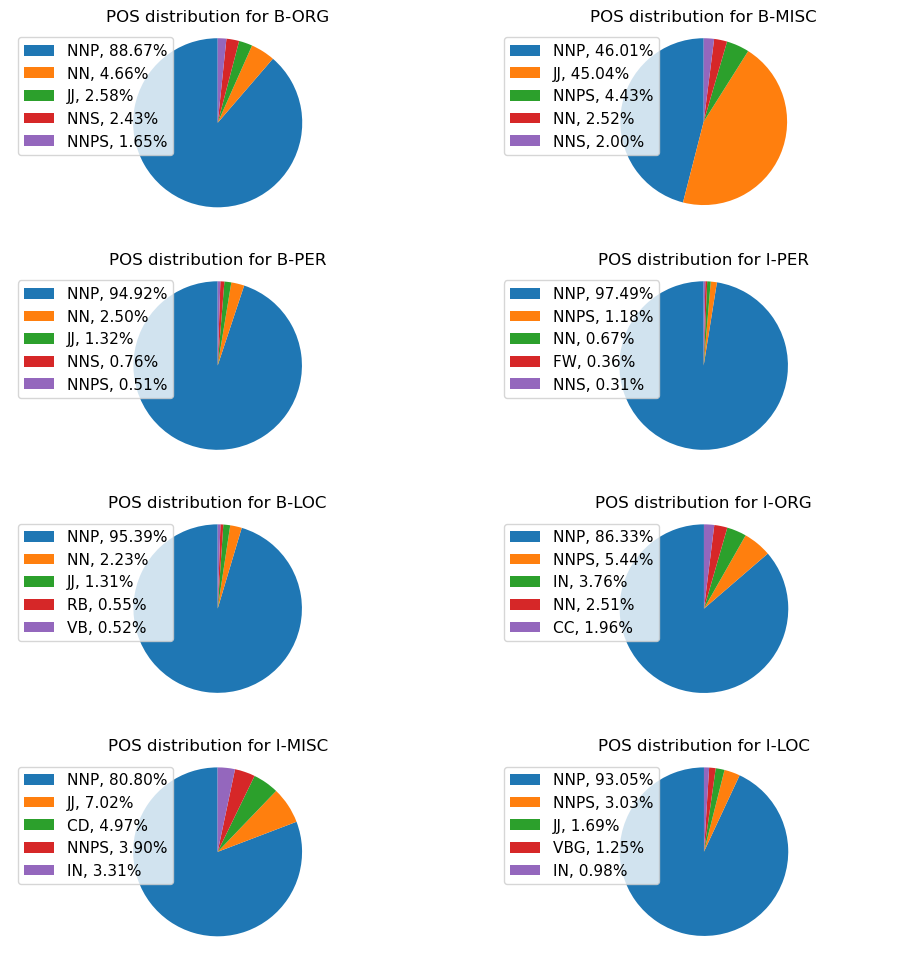

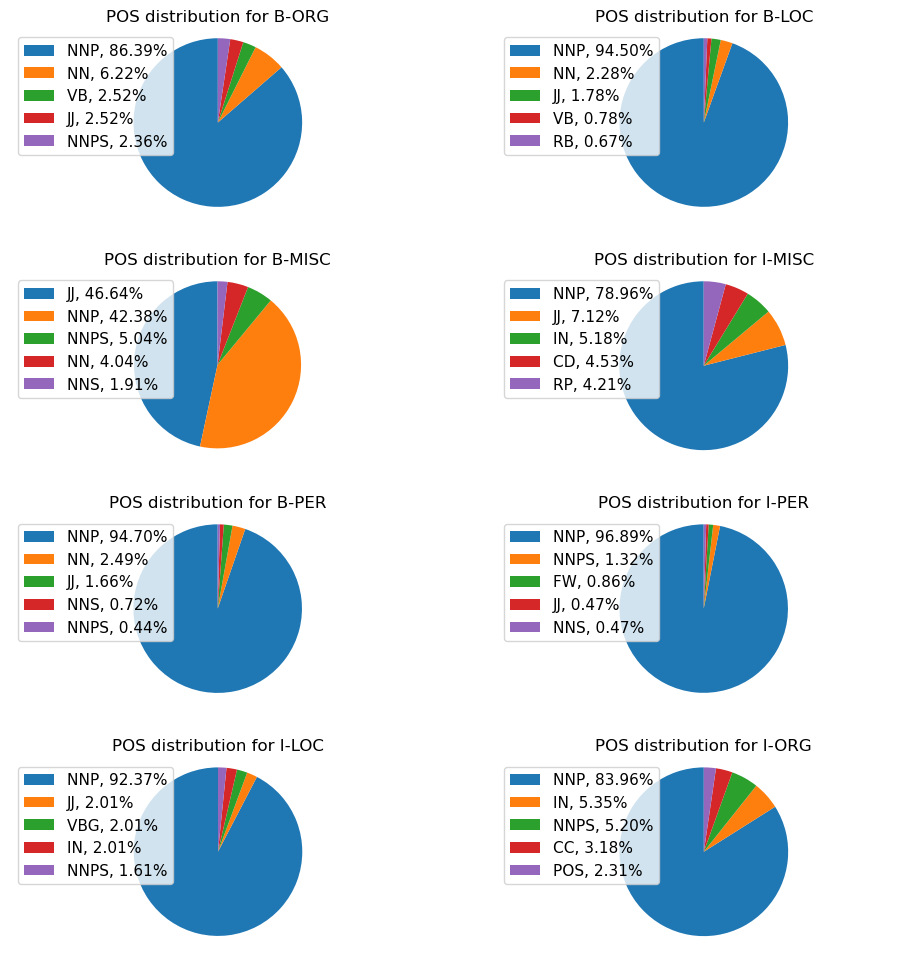

In [7]:
explore(root_filename, datafiles, column_types, plot=True)

## Data Exploration

### 1. Class label distribution

In [72]:
# train_labels_counter = get_class_labels_distribution(train_data, plot=True, train_data=True)
# exploration_results["entity count distribution train"] = train_labels_counter

In [73]:
# dev_labels_counter = get_class_labels_distribution(dev_data, plot=True, train_data=False)
# exploration_results["entity count distribution dev"] = dev_labels_counter

### 2. Top words per  category

In [74]:
# train_top_k_words = get_top_k_words_per_category(train_data, k=3)
# train_top_k_words
# top_words_dict = dict()
# top_words_count_dict = dict()

# for key, value in train_top_k_words.items():
#     top_words_dict[key] = value[0][0]
#     top_words_count_dict[key] = value[0][1]

# exploration_results["most occurring word train"] = top_words_dict
# exploration_results["most occurring word count train"] = top_words_count_dict
# plot_top_k_words(train_top_k_words)

In [75]:
# dev_top_k_words = get_top_k_words_per_category(dev_data, k=3)
# top_words_dict = dict()
# top_words_count_dict = dict()

# for key, value in dev_top_k_words.items():
#     top_words_dict[key] = value[0][0]
#     top_words_count_dict[key] = value[0][1]

# exploration_results["most occurring word dev"] = top_words_dict
# exploration_results["most occurring word count dev"] = top_words_count_dict

# plot_top_k_words(dev_top_k_words)

### 3. Exploration of given linguistic features like POS tags

In [76]:
# train_top_k_pos_tag = get_top_k_pos_per_category(train_data)
# del train_top_k_pos_tag['O']

# plot_pos_disribution(train_top_k_pos_tag)

In [77]:
# dev_top_k_pos_tag = get_top_k_pos_per_category(dev_data)
# del dev_top_k_pos_tag['O']

# plot_pos_disribution(dev_top_k_pos_tag)

### 4. Orthographic features distribution

In [14]:
## Getting a count of words that have the first letter capital for different classes

In [78]:
# train_ortho_counter = get_capital_words_count(train_data)
# exploration_results["capital words train"] = train_ortho_counter

In [79]:
# plt.bar(train_ortho_counter.keys(), train_ortho_counter.values())
# plt.title("Distribution of words having first letter as Captial for different classes")

In [80]:
# dev_ortho_counter = get_capital_words_count(dev_data)
# exploration_results["capital words dev"] = dev_ortho_counter

In [81]:
# plt.bar(dev_ortho_counter.keys(), dev_ortho_counter.values())
# plt.title("Distribution of words having first letter as Captial for different classes")